In [1]:
from collections import defaultdict 
import pydot
import statistics
import os
import sys
import csv
import math
import random
import time
import networkx as nx
from matplotlib.pyplot import figure
from networkx.algorithms.flow import edmonds_karp
from pathlib import Path, PureWindowsPath
import FordFulkerson as ff
import EdmondsKarp as EK
from multiprocessing import Pool
from collections import Counter
from IPython.display import Image, display
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
classes = {"ACCESS_MASK":0,"Atom":1,"BOOLEAN":2,"Debug":3,"Device":4,
                                 "Environment":5,"File":6,"HANDLE":7,"Job":8,"LONG":9,"LPC":10,
                                 "Memory":11,"NTSTATUS":12,"Object":13,"Other":14,"PHANDLE":15,
                                 "PLARGE_INTEGER":16,"Process":17,"PUNICODE_STRING":18,
                                 "PULONG":19,"PULARGE_INTEGER":20,"PVOID_SIZEAFTER":21,
                                 "PWSTR":22,"Registry":23,"Security":24,"Synchronization":25,
                                 "Time":26,"Transaction":27,"ULONG":28,"WOW64":29, "DummyStart":30,"DummyEnd":31}

In [3]:
def createDirs(fold):
    path = "DATASET F1/fold_" +str(fold)
    mal_path = path+ "/20%_test"
    train_path = path+ "/80%_train"
    benign_path = "DATASET F1/specimen_benign/20%_test"
    
    w_mal_path = PureWindowsPath(mal_path)
    w_train_path= PureWindowsPath(train_path)
    w_benign_path = PureWindowsPath(benign_path)
    print( mal_path+"\n"+ train_path+"\n"+ benign_path)
    print( w_mal_path, w_train_path, w_benign_path)

    filename = "default_G_tone_map"
    mapFilename = "default_unique_mapping"
    
    rootDir = [os.path.join(root, name)
             for root, dirs, files in os.walk(w_mal_path)
             for name in files
             if name.endswith(filename+".csv")]
    rootDir.sort()
    # for i in range(len(paths)):
    #     p = [os.path.join(root, name)
    #              for root, dirs, files in os.walk(paths[i]+"/"+path)
    #              for name in files
    #              if name.endswith(filename+".csv")]
    #     p.sort()
    #     rootDirs[i] = p
    # print(rootDirs[10])
    benignDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_benign_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    benignDir.sort()

    # for i in range(len(paths)):
    trainDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_train_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    trainDir.sort()
    #     trainDirs[i] = trainDir
    return [rootDir,benignDir,trainDir]

In [4]:
def createGraphs(dirs,npmode):
    rootDir = dirs[0]
    benignDir = dirs[1]
    trainDir = dirs[2]
    mal_gs = []
    mal_np_gs = []
    ben_gs = []
    train_gs = []
    train_np_gs = []
    ben_np_gs = []
    csm_vals = {}
    for i in range(len(rootDir)):
        A = np.array(getArray(rootDir[i]))
        G = nx.from_numpy_matrix(A)
        mal_gs.append(G)
        mal_np_gs.append(A)
        printProgressBar(i, len(rootDir)-1,prefix = 'malware gs')

    for i in range(len(trainDir)):
        A = np.array(getArray(trainDir[i]))
        G = nx.from_numpy_matrix(A)
        train_gs.append(G)
        train_np_gs.append(A)
        printProgressBar(i, len(trainDir)-1, prefix = 'train gs')
        
    for i in range(len(benignDir)):
        A = np.array(getArray(benignDir[i]))
        G = nx.from_numpy_matrix(A)
        ben_gs.append(G)
        ben_np_gs.append(A)
        printProgressBar(i, len(benignDir)-1, prefix = 'benign gs')
    if npmode: 
        return [mal_np_gs, ben_np_gs, train_np_gs]
    else: 
        return [mal_gs, ben_gs, train_gs]

In [5]:
def getArray (path):
    results = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile,csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            nums = []
            for i in row: 
                if i :
                    nums.append(int(i))
            results.append(nums)
    return results

# def writeCSV()
generic method to quickly write a graph to a csv file.

In [6]:
def writeCSV(g,path,name):
    path_spl = path.split('/')
    path_spl[-1] = name
    sp_path = '/'.join(path_spl)
    with open(sp_path, mode='w') as cvg_file:
        cvg_writer = csv.writer(cvg_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in g:
            cvg_writer.writerow(i)

In [7]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

# Flow map
## def createFlowMap(g):
* Given the capacity of each edge and the neighbors of each node of a graph, the function returns a NxN array tha represents the flow map of the given graph, having in each `g'[i][j]= MaxFlow(cap,neighs,i,j)`. **the base function used to permutate our original GrGs** 

## def createMap(dirs):
* wrapper method that calls createFlowMap(path) for every path in the dirs list. This method is used to run through the rootDir, benignDir and train Dir to create our point of reference

## def CSM(A,B):
* calculates the cosine similarity metric for two arrays A and B
   

In [8]:
def createFlowMap(capacity, neighbors): 
    values = [[0 for i in range(len(capacity))] for j in range(len(capacity))]

    for i in range(len(capacity)):
        for j in range(len(capacity)):
            values[i][j] = EK.EdmondsKarp(capacity,neighbors,i,j)
    return values

In [9]:
def createMap(paths):
    mal_paths = paths[0]
    benign_paths = paths[1]
    train_paths = paths[2]
    mals = {}
    bens = {}
    trains ={}
    mal_vals = []
    ben_vals = []
    train_vals = []
    
    for i in range(len(mal_paths)):
        cap, neig = EK.ParseGraph(mal_paths[i])
        mals[i]=[cap,neig]
        v = np.array(createFlowMap(cap,neig))
        x,y = v.shape
        mal_vals.append(np.reshape(v,x*y))
        printProgressBar(i, len(mal_paths)-1, length = 50,prefix = "malware")       

    for i in range(len(benign_paths)):
        cap, neig = EK.ParseGraph(benign_paths[i])
        bens[i]=[cap,neig]
        v =np.array(createFlowMap(cap,neig))
        x,y = v.shape
        ben_vals.append(np.reshape(v,x*y))
        printProgressBar(i, len(benign_paths)-1, length = 50,prefix = "benign")       

    for i in range(len(train_paths)):
        cap, neig = EK.ParseGraph(train_paths[i])
        trains[i]=[cap,neig]
        v = np.array(createFlowMap(cap,neig))
        x,y = v.shape
        train_vals.append(np.reshape(v,x*y))
        printProgressBar(i, len(train_paths)-1, length = 50,prefix = "train")       
    
    
    return [mal_vals,ben_vals,train_vals]

In [37]:
def calculateDifference(listA, listB, dirs,isBenign, metric = "csm"):
    ret_val = []
    rootDir = dirs[0]
    benDir = dirs[1]
    trainDir = dirs[2]
    if metric == "csm" :
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            val = []
            e_val = []
            for j in range(len(listB)):
                val.append(1-distance.cosine(listA[i], listB[j]))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
        return ret_val
    elif metric == "euc":
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.euclidean(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        return ret_val
    elif metric == "bray":
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            e_val = []
            for j in range(len(listB)):
                e_val.append(1-distance.braycurtis(listA[i], listB[j]))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        return ret_val
    elif metric == "sqeuc":
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.sqeuclidean(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        return ret_val
    elif metric == "cor":
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.correlation(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        return ret_val
    elif metric == "prod":
        for i in range(len(listA)):
            printProgressBar(i,len(listA)-1,length = min(len(listA), 50),prefix='diff calculation:')
            e_val = []
            for j in range(len(listB)):
                a= 1000.0/(1000.0+distance.correlation(listA[i], listB[j]))
                b = 1-distance.braycurtis(listA[i],listB[j])
                e_val.append(a*b)
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        return ret_val
    


In [11]:
def similarityMetric(sr):
    counterA = 0
    counterB = 0
    counterC = 0
    for i in sr :
        A,B = i[0].split(',')[0], i[0].split(',')[1]
        C,D = i[2].split(',')[0], i[2].split(',')[1]
        if A==C and B==D:
            counterA +=1
        if A==C or B==D:
            counterB +=1
        if A==C or A==D or B == C or B == D:
            counterC += 1
#     print("cA = %d (%f) cB= %d (%f) cC =%d (%f)"%(counterA, counterA/len(sr), counterB, counterB/len(sr), counterC, counterC/len(sr)))
    return [counterA/len(sr),counterB/len(sr),counterC/len(sr)]

In [12]:
def saveFigures(mal_th, ben_th, start, iteration):
    lists = [mal_th,ben_th]
    diffs = []
    v = 0
    for i in range(len(mal_th)):
        v = max(v,abs(mal_th[i]-ben_th[i]))
        diffs.append(abs(mal_th[i]-ben_th[i]))
    print(v)
    d = max(diffs)
    print(d, mal_th[diffs.index(d)])

    for i in lists:
        plt.plot(i,marker= 11)
    plt.title("max dif at %f"%(diffs[diffs.index(d)]))
    plt.legend(["True positives","False positives"])
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0,step, 1))
    plt.ylabel("")
    plt.draw()
    try:
        os.mkdir(str(iteration))
    except OSError:
#         print ("Creation of the directory %s failed" % str(iteration))
        pass
    else:
        print ("Successfully created the directory %s" % str(iteration))
    plt.savefig(str(iteration)+"/"+str(start)+".png")
    plt.clf()



In [13]:
def detection(ben, mal, itr, step, metric = 'Csm' ):
    dif = ben[0]-ben[-1]
    thresh = [ben[-1]+i*dif/step for i in range(step)]
    m = np.array(sum(i > thresh for i in mal)/len(mal))
    p = np.array(sum(i > thresh for i in ben)/len(ben))
    for i in [m,p]:
        plt.plot(i)
    plt.yticks(np.arange(0,1.05,0.05))
    plt.xticks(np.arange(0,len(thresh),1))
    plt.draw()
    plt.title('detection at '+str(itr)+ ' iteration')
    plt.savefig(metric+"--"+ str(itr)+'--flow.png')
    plt.clf()
    return [m, p]


In [14]:
def sortTests(test):
    sortedTests =[]
    for i in range(len(test)):
        srTest = sorted(test[i], key = lambda kv:kv[1],reverse = True)
        sortedTests.append(srTest)
        
    return sortedTests

In [15]:
def detectSteps(testA, testB,step, metric = "Csm"):
    detect = []
    for i in range(len(testA)):
        detect.append(detection(testA[i], testB[i], i, step, metric=metric))
    return detect

In [16]:
def simAverages(malTest, benTest, metric):
    similarities = [similarityMetric(malTest[i]) for i in range(len(malTest))]
    for i in similarities :
        print(i)
    counts = [[i[j] for i in similarities] for j in range(len(i))]
    avg = [statistics.mean(i) for i in counts]
    print("---------------")
    print(metric)
    print("---------------")
    print(avg)

In [17]:
itDirs = [createDirs(i) for i in range(1,6)]

maps = [createMap(itDirs[i]) for i in range(len(itDirs))]

DATASET F1/fold_1/20%_test
DATASET F1/fold_1/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_1\20%_test DATASET F1\fold_1\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_2/20%_test
DATASET F1/fold_2/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_2\20%_test DATASET F1\fold_2\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_3/20%_test
DATASET F1/fold_3/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_3\20%_test DATASET F1\fold_3\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_4/20%_test
DATASET F1/fold_4/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_4\20%_test DATASET F1\fold_4\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_5/20%_test
DATASET F1/fold_5/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_5\20%_test DATASET F1\fold_5\80%_train DATASET F1\specimen_benign\20%_test
malware |██████████████████████████████████████████████████| 100.0% 
benign |█████████████

In [18]:
t = time.time()
malwareTests = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False) for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTests = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True) for i in range(len(maps))]

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware took 151.420086 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [19]:
sortBenignTests= sortTests(benignTests)

sortMalwareTests =  sortTests(malwareTests)

In [20]:
malwares =  [[sortMalwareTests[j][i][1] for i in range(len(sortMalwareTests[j]))] 
             for j in range(len(sortMalwareTests))]
benigns =  [[sortBenignTests[j][i][1] for i in range(len(sortBenignTests[j]))] 
             for j in range(len(sortBenignTests))]

In [21]:
t = time.time()
malwareTestsEuc = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "euc") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsEuc = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "euc") for i in range(len(maps))]

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware took 51.492804 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [22]:
sortBenignTestsEuc = sortTests(benignTestsEuc)
sortMalwareTestsEuc = sortTests(malwareTestsEuc)

In [23]:
malwaresEuc =  [[sortMalwareTestsEuc[j][i][1] for i in range(len(sortMalwareTestsEuc[j]))] 
             for j in range(len(sortMalwareTestsEuc))]

benignsEuc =  [[sortBenignTestsEuc[j][i][1] for i in range(len(sortBenignTestsEuc[j]))] 
             for j in range(len(sortBenignTestsEuc))]



In [38]:
t = time.time()
malwareTestsBray = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "bray") for i in range(len(maps))]
print("malware euc took %f seconds"%(time.time()-t))

benignTestsBray = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "bray") for i in range(len(maps))]

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware euc took 81.145879 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [39]:
sortBenignTestsBray = sortTests(benignTestsBray)
sortMalwareTestsBray = sortTests(malwareTestsBray)

In [40]:
malwaresBray =  [[sortMalwareTestsBray[j][i][1] for i in range(len(sortMalwareTestsBray[j]))] 
             for j in range(len(sortMalwareTestsBray))]

benignsBray =  [[sortBenignTestsBray[j][i][1] for i in range(len(sortBenignTestsBray[j]))] 
             for j in range(len(sortBenignTestsBray))]



In [27]:
t = time.time()
malwareTestsSq = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "sqeuc") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsSq = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "sqeuc") for i in range(len(maps))]

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware took 51.000294 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [28]:
sortBenignTestsSq = sortTests(benignTestsSq)
sortMalwareTestsSq = sortTests(malwareTestsSq)

In [30]:
malwaresSq =  [[sortMalwareTestsSq[j][i][1] for i in range(len(sortMalwareTestsSq[j]))] 
             for j in range(len(sortMalwareTestsSq))]

benignsSq =  [[sortBenignTestsSq[j][i][1] for i in range(len(sortBenignTestsSq[j]))] 
             for j in range(len(sortBenignTestsSq))]



In [31]:
t = time.time()
malwareTestsCor = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "cor") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsCor = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "cor") for i in range(len(maps))]

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware took 221.445111 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [32]:
sortBenignTestsCor = sortTests(benignTestsCor)
sortMalwareTestsCor = sortTests(malwareTestsCor)

In [33]:
malwaresCor =  [[sortMalwareTestsCor[j][i][1] for i in range(len(sortMalwareTestsCor[j]))] 
             for j in range(len(sortMalwareTestsCor))]

benignsCor =  [[sortBenignTestsCor[j][i][1] for i in range(len(sortBenignTestsCor[j]))] 
             for j in range(len(sortBenignTestsCor))]



In [41]:
t = time.time()
malwareTestsProd = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "prod") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsProd = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "prod") for i in range(len(maps))]
sortBenignTestsProd = sortTests(benignTestsProd)
sortMalwareTestsProd = sortTests(malwareTestsProd)

diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
diff calculation: |██████████████████████████████████████████████████| 100.0% 
malware took 317.055557 seconds
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 
diff calculation: |███████████████████████████████████| 100.0% 


In [42]:
malwaresProd =  [[sortMalwareTestsProd[j][i][1] for i in range(len(sortMalwareTestsProd[j]))] 
             for j in range(len(sortMalwareTestsProd))]

benignsProd =  [[sortBenignTestsProd[j][i][1] for i in range(len(sortBenignTestsProd[j]))] 
             for j in range(len(sortBenignTestsProd))]



In [43]:
steps = 20
detect = detectSteps(benigns,malwares,steps, metric= "Csm")
detectEuc = detectSteps(benignsEuc,malwaresEuc, steps, metric="Euc")
detectBray = detectSteps(benignsBray,malwaresBray, steps, metric="Bray")
detectSq = detectSteps(benignsSq,malwaresSq, steps, metric="Sqeuc")
detectCor = detectSteps(benignsCor, malwaresCor, steps, metric="Dist Cor")
detectProd = detectSteps(benignsProd, malwaresProd, steps, metric="Prod")

<Figure size 432x288 with 0 Axes>

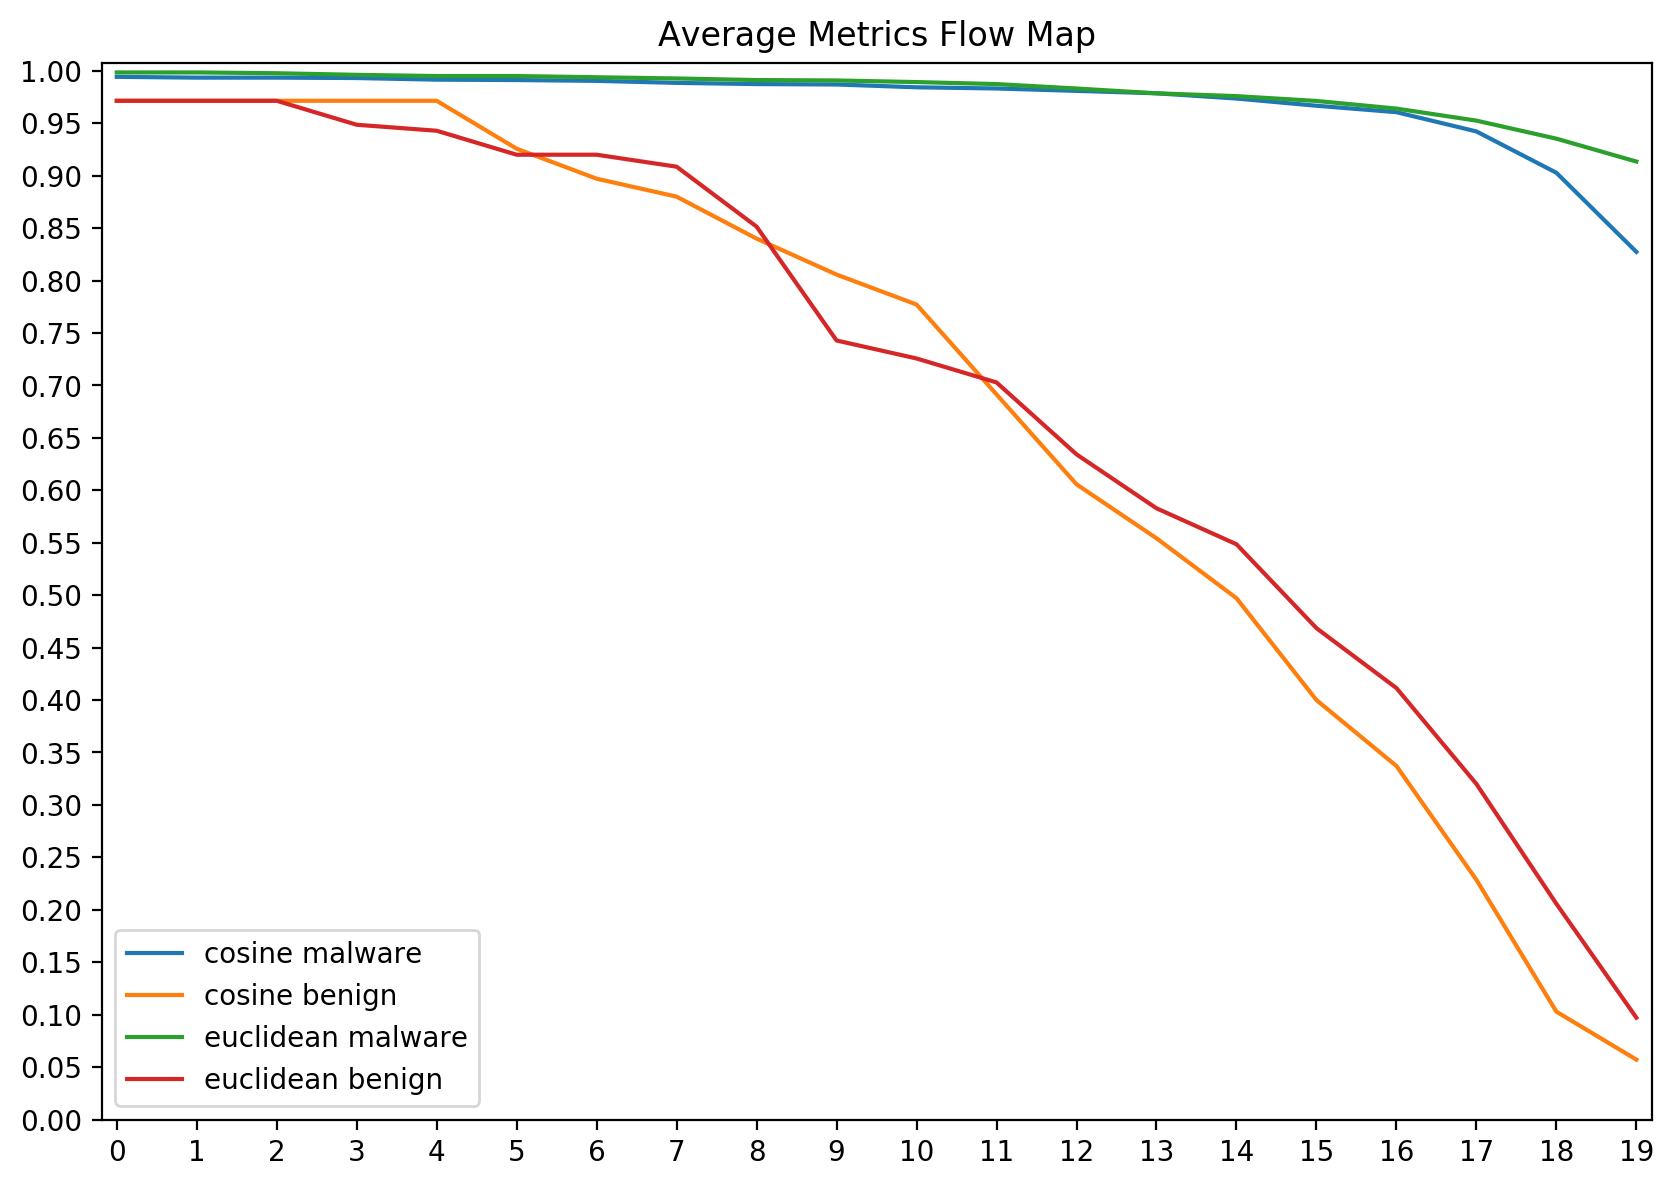

In [46]:
mal_det = np.array([detect[i][0] for i in range(len(detect))])
ben_det = np.array([detect[i][1] for i in range(len(detect))])
mal_euc = np.array([detectEuc[i][0] for i in range(len(detectEuc))])
ben_euc = np.array([detectEuc[i][1] for i in range(len(detectEuc))])
mal_bray = np.array([detectBray[i][0] for i in range(len(detectBray))])
ben_bray = np.array([detectBray[i][1] for i in range(len(detectBray))])
mal_sq = np.array([detectSq[i][0] for i in range(len(detectSq))])
ben_sq = np.array([detectSq[i][1] for i in range(len(detectSq))])
mal_cor = np.array([detectCor[i][0] for i in range(len(detectCor))])
ben_cor = np.array([detectCor[i][1] for i in range(len(detectCor))])
mal_prod = np.array([detectProd[i][0] for i in range(len(detectProd))])
ben_prod = np.array([detectProd[i][1] for i in range(len(detectProd))])

avg_det = np.mean(mal_det,axis=0)
avg_det_b = np.mean(ben_det,axis=0)
avg_euc = np.mean(mal_euc, axis =0)
avg_euc_b = np.mean(ben_euc,axis = 0)
avg_bray = np.mean(mal_bray, axis =0)
avg_bray_b = np.mean(ben_bray,axis = 0)
avg_sq = np.mean(mal_sq, axis =0)
avg_sqeuc_b = np.mean(ben_sq,axis = 0)
avg_cor = np.mean(mal_cor, axis =0)
avg_cor_b = np.mean(ben_cor,axis = 0)
avg_prod = np.mean(mal_prod, axis =0)
avg_prod_b = np.mean(ben_prod,axis = 0)


figure(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')
plt.margins(0.01)
plt.title("Average Metrics Flow Map")
# plt.plot(avg_det)
# plt.plot(avg_det_b)
plt.plot(avg_euc)
plt.plot(avg_euc_b)
# plt.plot(avg_bray)
# plt.plot(avg_bray_b)
# plt.plot(avg_sq)
# plt.plot(avg_sqeuc_b)
# plt.plot(avg_cor)
# plt.plot(avg_cor_b)
plt.plot(avg_prod)
plt.plot(avg_prod_b)

plt.xticks(np.arange(0,len(avg_det),1))
plt.yticks(np.arange(0,1.01,0.05))
plt.legend(["cosine malware", "cosine benign","euclidean malware", "euclidean benign", "BC malware", 
            "BC benign","Sqeuc malware", "Sqeuc benign","Correlation malware", "Correlation benign"])
plt.savefig("averages of all metrics.png")

In [36]:
simAverages(sortMalwareTests,sortBenignTests,"Csm")
print("===========================================")
print()
simAverages(sortMalwareTestsEuc,sortBenignTestsEuc,"Euc")
print("===========================================")
print()
simAverages(sortMalwareTestsBray,sortBenignTestsBray,"Bray")
print("===========================================")
print()
simAverages(sortMalwareTestsSq,sortBenignTestsSq,"Sq")
print("===========================================")
print()
simAverages(sortMalwareTestsCor,sortBenignTestsCor,"Cor")

[0.6641074856046065, 0.8061420345489443, 0.8157389635316699]
[0.6641074856046065, 0.8042226487523992, 0.817658349328215]
[0.6583493282149712, 0.7965451055662188, 0.8157389635316699]
[0.6525911708253359, 0.7907869481765835, 0.8195777351247601]
[0.6275992438563327, 0.782608695652174, 0.7996219281663516]
---------------
Csm
---------------
[0.6533509428211706, 0.796061086539264, 0.8136671879365333]

[0.654510556621881, 0.7888675623800384, 0.8042226487523992]
[0.6429942418426103, 0.7869481765834933, 0.8023032629558541]
[0.6525911708253359, 0.7907869481765835, 0.8080614203454894]
[0.6506717850287908, 0.781190019193858, 0.8023032629558541]
[0.6200378071833649, 0.7674858223062382, 0.782608695652174]
---------------
Euc
---------------
[0.6441611123003965, 0.7830557057280423, 0.7998998581323542]

[0.6756238003838771, 0.8214971209213052, 0.8310940499040307]
[0.6641074856046065, 0.8042226487523992, 0.8214971209213052]
[0.6583493282149712, 0.800383877159309, 0.8195777351247601]
[0.656429942418426